In [1]:
import torchvision.models as models
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lib.dataset import FolderDataset


In [2]:
model = models.vgg19(pretrained=True)

In [3]:
df = pd.read_csv('data/full_clear_data.csv')

In [4]:
all_imgs = df.local_path.to_list()
ids = df.id.to_list()
transforms = T.Compose([T.Resize(256),
                        T.CenterCrop(224),
                        T.RandomHorizontalFlip(),
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])

In [5]:
full_dataset = FolderDataset(all_imgs, ids, transforms)
batch_size = 20
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size)

In [6]:
from typing import Dict, Iterable, Callable
import torch.nn as nn
import torch

class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        _ = self.model(x)
        return self._features[self.layers[0]]


In [7]:
device = 'cuda'

resnet_features = FeatureExtractor(model, layers=['classifier.5'])
resnet_features.eval()
resnet_features.to(device)

FeatureExtractor(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [8]:
import pickle

with open('checkpoints/tree_db.pt', 'rb') as f:
    tree = pickle.loads(f.read())
tree.index()

with open('checkpoints/lsh_db.pt', 'rb') as f:
    hash_lsh = pickle.loads(f.read())

In [9]:
from datasketch import MinHash

In [56]:
tree.__dict__.keys()

dict_keys(['l', 'k', 'hashtables', 'hashranges', 'keys', 'sorted_hashtables'])

In [10]:
from tqdm.notebook import tqdm_notebook
from typing import List
import os
import matplotlib.pyplot as plt
import cv2



def collections_check_filter(query_sample_id: int,
                             result_ids: List[int]) -> List[int]:
    collection_id = df[df['id'] == query_sample_id].iloc[0].collectionId
    if pd.isna(collection_id):
        return result_ids
    df_ids_filter = df[df['id'].isin(result_ids)]
    filtred_results = df_ids_filter.loc[df_ids_filter['collectionId'] != collection_id].id.to_list()
    return filtred_results


def plot_img(img_ids: List[int]):
    img_paths = df[df['id'].isin(img_ids)].local_path.to_list()
    pic_box = plt.figure(figsize=(20, 20))
    for i, img_path in enumerate(img_paths):
        pic_box.add_subplot(2,5,i+1)
        plt.imshow(img_path.permute(1, 2, 0))
        plt.axis('off')
    plt.show()


duplicates_search_res = []
iter_num = 0
for batch in tqdm_notebook(full_loader):
    batch = batch[0].to(device)
    batch_features = resnet_features(batch).cpu()
    for features in batch_features:
        features = features.squeeze(0).detach().ceil().int().numpy()
        m_hash = MinHash(50)
        m_hash.update(features)
        result = tree.query(m_hash, 5)
        hash_res = hash_lsh.query(m_hash)
        query_sample_id = df.iloc[iter_num].id
        filtred_tree_results = collections_check_filter(query_sample_id, result)
        filtred_hash_results = collections_check_filter(query_sample_id, hash_res)
        iter_num += 1
        if len(filtred_tree_results) > 1 or len(filtred_hash_results) > 1:
            duplicates_search_res += [{'query_id': query_sample_id,
                                       'tree_search_id': filtred_tree_results,
                                       'hash_search_id': filtred_hash_results}]
    if iter_num > 10000:
        break
    

  0%|          | 0/49218 [00:00<?, ?it/s]

/home/neiromed/anaconda3/envs/image_similarity/lib/python3.9/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [53]:
print(tree.__dict__.keys())
tree

dict_keys(['l', 'k', 'hashtables', 'hashranges', 'keys', 'sorted_hashtables'])


In [43]:
from datasketch import MinHash
data = [[key] for key in tree.keys[26152153]]
for minhash in MinHash.generator(data, num_perm=50):
    # do something useful
    print(tree.query(minhash, 5))

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [11]:
num = 12
dupl_ids = duplicates_search_res[num]['tree_search_id']
q_id = duplicates_search_res[num]['query_id']
print(q_id)
df[df['id'].isin(dupl_ids)]

26152153


,id,externalId,tokenName,collectionId,collectionName,collectionDescription,contractAddress,tokenDescription,url,metaUrl,local_path
266439,26427050,4086265121879708550233116660817663654490857520...,Ai Daring Apes #1,1791489,Ai Daring Apes,The AI Daring Apes is a private collection of ...,0x2953399124f0cbb46d2cbacd8a89cf0599974963,NaN,https://lh3.googleusercontent.com/IRicXZLJ3dEj...,NaN,/mnt/0806a469-d019-4d6a-be45-7cff5d66eb22/data...


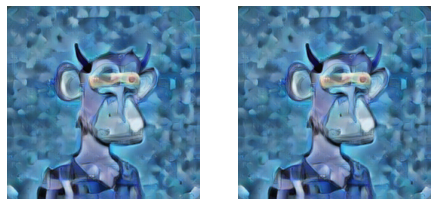

In [12]:
def plot_img(img_ids: List[int]):
    img_paths = df[df['id'].isin(img_ids)].local_path.to_list()
    pic_box = plt.figure(figsize=(20, 20))
    for i, img_path in enumerate(img_paths[:10]):
        pic_box.add_subplot(2,5,i+1)
        img = cv2.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

if not q_id in duplicates_search_res[num]['tree_search_id']:
    duplicates_search_res[num]['tree_search_id'].insert(0, q_id)
plot_img(duplicates_search_res[num]['tree_search_id'])

In [ ]:
a = list(range(5))
slice_obj = slice(10)
a[slice_obj]

In [ ]:
slice